PyTorch Lightning
=================



## Introdução



O `PyTorch` é um módulo poderoso para criar e treinar redes neurais. Na aula anterior nós vimos como criar uma MLP simples utilizando este módulo.

O `PyTorch Lightning` é um módulo feito para facilitar a criação e treinamento de redes neurais utilizando o `PyTorch`. Não é *necessário* utilizar o `PyTorch Lightning`, porém existem diversas vantagens de se fazer isso, como por exemplo:

1.  Criação e treino de redes neurais utilizando códigos mais curtos e mais expressivos, resultando em menos erros e maior facilidade de apuração;

2.  Maior facilidade de trocar entre treino da rede neural na CPU ou na GPU;

3.  Maior facilidade de paralelizar o treino da rede neural;

4.  Possibilidade de criar um pipeline de treino de redes neurais totalmente reprodutível.

Neste notebook veremos como criar e treinar uma rede neural utilizando o `PyTorch Lightning`.



## Importações e constantes



In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

NUM_EPOCAS = 20

## Objetivo



Criar uma rede neural tipo MLP utilizando o `PyTorch Lightning` e treinar, validar e testar esta rede no conjunto de dados de pinguins (problema de regressão).



## Coletando os dados



Vamos coletar os dados de pinguins disponíveis no `seaborn`.



In [3]:
features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
target = ["body_mass_g"]

df = sns.load_dataset("penguins")

df = df.reindex(features + target, axis=1)
df = df.dropna()

Separação dos dados de teste (também conhecido com dados *holdout*).



In [4]:
indices = df.index
indices_treino_val, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_val = df.loc[indices_treino_val]
df_teste = df.loc[indices_teste]

X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

Separação dos dados de treino e validação. O conjunto de validação é utilizado no treinamento de redes neurais para identificar quando a rede neural está sobreajustando nos dados durante o treinamento (*overfitting*).



In [5]:
indices = df_treino_val.index
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_val = df.loc[indices_val]

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

Todo normalizador deve se ajustar apenas ao conjunto de treino. Aqui utilizaremos o normalizador pelo máximo absoluto.



In [6]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

Para trabalhar com o `PyTorch` nós precisamos que os dados sejam convertidos para tensores. Utilizaremos tensores de 32 bits que apresentam bom balanço entre precisão e consumo de memória.



In [7]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

## DataModule (simplificado)



Agora precisamos criar uma instância da classe `L.LightningDataModule` que será utilizada durante o treinamento da rede neural pelo `PyTorch Lightning`.

O argumento `tamanho_lote` está relacionado ao processo de loteamento de dados, que significa dividir os dados em conjuntos menores para realizar o treinamento da rede em etapas. É muito comum utilizar potências de 2 para este valor. A estratégia de loteamento é necessária quando os dados são muito volumosos (ocupam muito espaço na memória). Aqui não seria necessário, porém utilizaremos para deixar o notebook mais completo.

O argumento `num_trabalhadores` é a quantidade de unidades de processamento que serão utilizadas para a manipulação dos dados.



In [8]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

## DataModule (completo)



É possível fazer com que a instância de `L.LightningDataModule` contenha *todos* os passos para criar, transformar e dividir o dataset. Apesar de parecer ser mais complicado fazer desta forma, é preferível para que todas as ações referentes a dados fiquem registradas no mesmo local. Observe que não tem nenhuma informação nova aqui que já não foi apresentada acima. Tente sempre seguir desta maneira se possível.



In [9]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        tamanho_lote=256,
        num_trabalhadores=2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

    def prepare_data(self):
        """Local onde se faz o download do dataset. No caso do `seaborn`, ele
        deve baixar o dataset quando se usa pela primeira vez e por isso
        incluímos este código aqui.

        Não altere o estado da sua classe neste método!

        Se você não precisa fazer download de um dataset, pode eliminar este
        método.

        """
        sns.load_dataset("penguins")

    def setup(self, stage):
        """Ocorre após o `prepare_data`. Aqui devemos alterar o estado da classe
        para adicionar as informações referentes aos conjuntos de treino, teste
        e validação. O argumento `stage` deve existir e ele indica em qual
        estágio o processo de treino está (pode ser `fit` para
        treinamento/validação e `test` para teste).

        É nesta etapa onde aplicamos transformações aos dados caso necessário.

        """
        features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]
        target = ["body_mass_g"]

        df = sns.load_dataset("penguins")

        df = df.reindex(features + target, axis=1)
        df = df.dropna()

        indices = df.index
        indices_treino_val, indices_teste = train_test_split(
            indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
        )

        df_treino_val = df.loc[indices_treino_val]
        df_teste = df.loc[indices_teste]

        indices = df_treino_val.index
        indices_treino, indices_val = train_test_split(
            indices,
            test_size=TAMANHO_TESTE,
            random_state=SEMENTE_ALEATORIA,
        )

        df_treino = df.loc[indices_treino]
        df_val = df.loc[indices_val]

        X_treino = df_treino.reindex(features, axis=1).values
        y_treino = df_treino.reindex(target, axis=1).values

        self.x_scaler = MaxAbsScaler()
        self.x_scaler.fit(X_treino)

        self.y_scaler = MaxAbsScaler()
        self.y_scaler.fit(y_treino)

        if stage == "fit":
            X_val = df_val.reindex(features, axis=1).values
            y_val = df_val.reindex(target, axis=1).values

            X_treino = self.x_scaler.transform(X_treino)
            y_treino = self.y_scaler.transform(y_treino)

            X_val = self.x_scaler.transform(X_val)
            y_val = self.y_scaler.transform(y_val)

            self.X_treino = torch.tensor(X_treino, dtype=torch.float32)
            self.y_treino = torch.tensor(y_treino, dtype=torch.float32)

            self.X_val = torch.tensor(X_val, dtype=torch.float32)
            self.y_val = torch.tensor(y_val, dtype=torch.float32)

        if stage == "test":
            X_teste = df_teste.reindex(features, axis=1).values
            y_teste = df_teste.reindex(target, axis=1).values

            X_teste = self.x_scaler.transform(X_teste)
            y_teste = self.y_scaler.transform(y_teste)

            self.X_teste = torch.tensor(X_teste, dtype=torch.float32)
            self.y_teste = torch.tensor(y_teste, dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

## Criando a rede neural



Criar uma rede neural utilizando o `PyTorch Lightning` é muito similar ao que fizemos quando criamos uma rede utilizando o `PyTorch`. Desta vez, devemos criar uma classe que herda de `L.LightningModule` e registrar como proceder durante as etapas de treino, validação e teste.



In [10]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

## Treinando a rede



Para treinar uma rede do `PyTorch Lightning` nós precisamos criar um treinador. É o treinador que irá controlar os processos do treino como, por exemplo, quantas épocas a rede neural será treinada.



In [11]:
treinador = L.Trainer(max_epochs=NUM_EPOCAS)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/daniel/data/Venv/ilumpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(


Precisamos também criar uma instância da classe `DataModule` que definimos acima.



In [12]:
dm = DataModule()

Antes de treinar, precisamos também criar uma instância da rede neural.



In [13]:
num_dados_de_entrada = 3
num_dados_de_saida = 1
neuronios_c1 = 3
neuronios_c2 = 2

minha_mlp = MLP(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

Finalmente, temos tudo que precisamos. Podemos rodar o método `fit` do nosso treinador na nossa instância da rede neural, fornecendo também uma instância do `DataModule` como argumento.



In [14]:
treinador.fit(minha_mlp, dm)


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 23    
---------------------------------------
23        Trainable params
0         Non-trainable params
23        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/daniel/data/Venv/ilumpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/daniel/data/Venv/ilumpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/daniel/data/Venv/ilumpy/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 41.96it/s, v_num=23, loss=0.0848]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00, 25.72it/s, v_num=23, loss=0.0839, val_loss=0.094]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00, 25.12it/s, v_num=23, loss=0.083, val_loss=0.093] 
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00, 34.56it/s, v_num=23, loss=0.0822, val_loss=0.092]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00, 32.40it/s, v_num=23, loss=0.0813, val_loss=0.0911]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00, 30.88it/s, v_num=23, loss=0.0804, val_loss=0.0902]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00, 30.37it/s, v_num=23, loss=0.0796, val_loss=0.0892]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 2/2 [00:00<00:00, 35.04it/s, v_num=23, loss=0.0788, val_loss=0.0883]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2/2 [00:00<00:00, 19.40it/s, v_num=23, loss=0.0696, val_loss=0.0775]


## Curva de aprendizado



Por quantas épocas precisamos treinar uma rede neural? Se treinarmos por poucas épocas, a rede não irá atingir seu potencial e teremos um modelo com alto viés e baixa variância, levando a um subajuste (underfitting). Se treinarmos por muitas épocas, a rede irá &ldquo;decorar&rdquo; os dados e teremos um modelo com baixo viés e alta variância, levando a um sobreajuste (overfitting).

Uma forma de encontrar uma quantidade razoável de épocas de treino é observando a curva de aprendizado. Esta curva apresenta a perda (loss) do conjunto de treino e do conjunto de validação durante cada época de treino. Quando a rede neural está na região de subajuste, tanto a perda do conjunto de treino quanto a perda do conjunto de validação tendem a reduzir com o passar das épocas. Quando a rede está na região de sobreajuste, a perda do conjunto de treino permanece reduzindo, porém a perda do conjunto de validação passa a aumentar, mostrando que a rede neural &ldquo;bitolou&rdquo; nos dados de treino. O ponto de parada é justamente o ponto de mínimo da curva de aprendizado da validação.



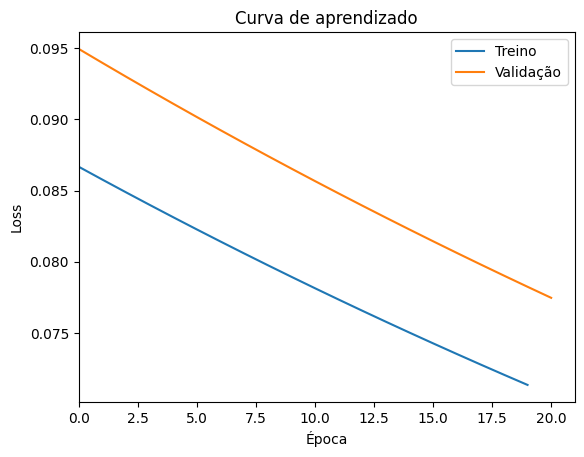

In [22]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

## Testando a rede



Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [16]:
minha_mlp.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=2, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [17]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

1632.4979196178913


## Salvando o modelo



O próprio treinador do `PyTorch Lightning` já salva os modelos durante o treinamento. Para usar destes modelos salvos automaticamente, leia a referência [2].

Outra alternativa é salvar apenas os pesos e vieses da rede neural em um arquivo no seu computador. Para isso, podemos utilizar o módulo `pickle`.



In [18]:
nome_arquivo = "meu_modelo.p"
pickle.dump(minha_mlp.state_dict(), open(nome_arquivo, "wb"))

Tendo este arquivo salvo, podemos carregar ele usando o `pickle` novamente.



In [19]:
pesos_e_vieses = pickle.load(open(nome_arquivo, "rb"))

minha_outra_mlp = MLP(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

minha_outra_mlp.load_state_dict(pesos_e_vieses)

<All keys matched successfully>

Vamos testar se funciona.



In [20]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = minha_outra_mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

1632.4979196178913


## Treinando a rede na GPU



Se você estiver em um ambiente computacional com placa computacional gráfica (GPU) devidamente configurada para o treinamento de redes neurais, então você pode treinar a sua rede neural na GPU. Para isso, basta criar um treinador e passar a string `"gpu"` no argumento `accelerator`. O treino da rede procede normalmente como visto acima. O argumento `devices` do treinador indica quantas unidades computacionais da CPU serão utilizadas no treino da rede.



In [21]:
treinador = L.Trainer(
    devices=4,
    accelerator="gpu",
 )

MisconfigurationException: No supported gpu backend found!

## XKCD relevante



![img](https://imgs.xkcd.com/comics/standards.png)

`Imagem: Standards (XKCD) disponível em https://xkcd.com/927`



## Referências



1.  Site oficial do `PyTorch Lightning` [https://lightning.ai/docs/pytorch/stable/](https://lightning.ai/docs/pytorch/stable/)

2.  Tutorial sobre como carregar modelos [https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#save-a-checkpoint](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#save-a-checkpoint)

